In [1]:
!pip install --quiet scanpy anndata matplotlib seaborn

In [ ]:
!pip install scanpy anndata matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 466.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 230.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 148.8 kB/s eta 0:00:00a 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 258.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 293.7 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 285.3 kB/s eta 0:00:0000:0100:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 213.2 kB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 146.7 kB/s eta 0:00:0000:0200:12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 243.2 kB/s eta 0:00:0000:0100:02
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [47]:
import os
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, frameon=True, figsize=(6,4))
np.random.seed(42)

In [48]:
adata = sc.read_10x_mtx(
    '/projects/mipt_dbmp_biotechnology/single_cell/H068_sample_filtered_feature_bc_matrix/',
    var_names='gene_symbols',
    cache=True
)

adata
adata.shape

... reading from cache file cache/projects-mipt_dbmp_biotechnology-single_cell-H068_sample_filtered_feature_bc_matrix-matrix.h5ad


(9234, 36601)

1. количество клеток = 9234, генов = 36601
Фильтрация CellRanger:
CellRanger использует “knee plot” и “inflection point” для определения реальных клеток.
Удаляются: Клетки с очень низкой суммарной экспрессией (считаются пустыми/шумом)
Клетки с высоким процентом митохондриальных генов (считаются мёртвыми или апоптотическими)
Эти шаги позволяют отделить настоящие клетки от фонового шума.

2. 
min.features=200 → удаляются клетки с <200 экспрессированных генов
min.cells=3 → удаляются гены, экспрессируемые меньше чем в 3 клетках
До фильтрации:
Клеток: 9234
Генов: 36601
После фильтрации CellRanger и создания объекта Seurat/Scanpy с min.cells=3, min.features=200:
Клеток: 8632
Генов: 22584

In [49]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata

filtered out 601 cells that have less than 200 genes expressed
filtered out 14017 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 8633 × 22584
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [50]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # человеческие митохондриальные гены начинаются с MT-
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


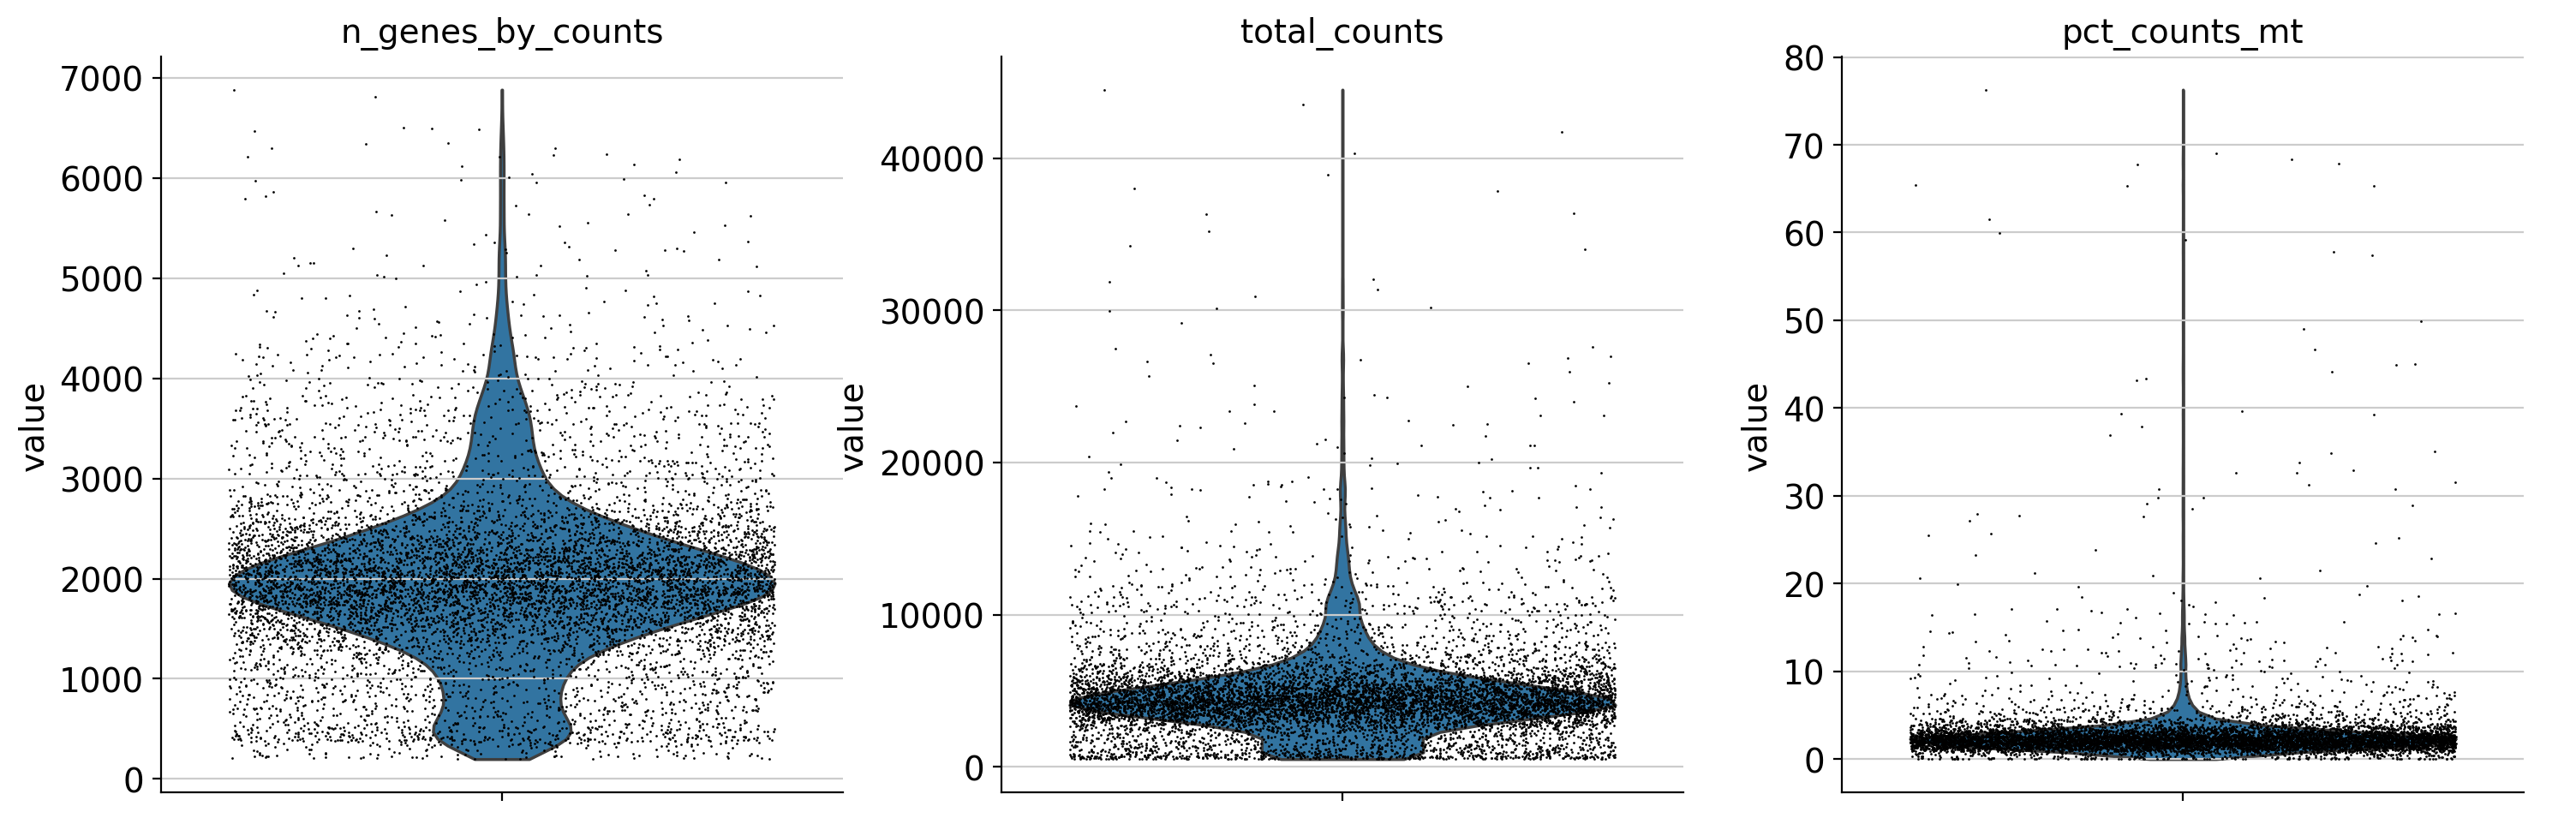

In [51]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)



In [52]:
adata = adata[adata.obs['n_genes_by_counts'] < 5000, :]
adata = adata[adata.obs['pct_counts_mt'] < 10, :]

adata

View of AnnData object with n_obs × n_vars = 8367 × 22584
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [53]:
adata = adata.copy() 
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


5 самых вариабельных генов

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


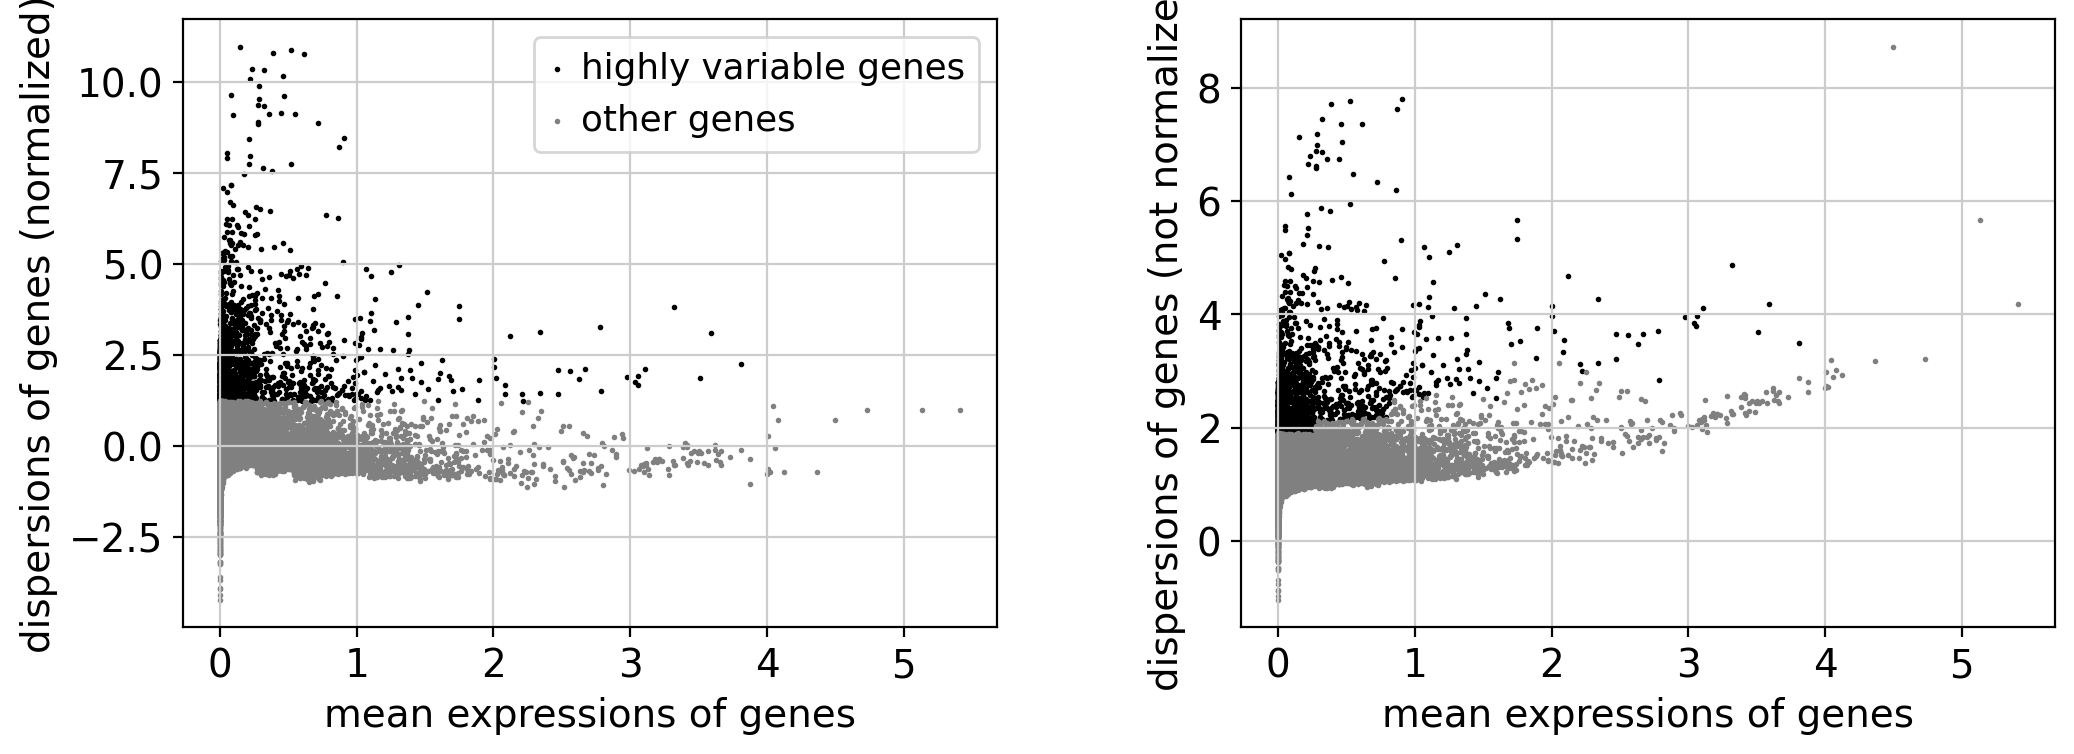

gene_ids    feature_types  n_cells     mt  \
IGKV3-11   ENSG00000241351  Gene Expression      122  False   
IGLV3-25   ENSG00000211659  Gene Expression       92  False   
IGKV1-16   ENSG00000240864  Gene Expression       43  False   
IGKV3-15   ENSG00000244437  Gene Expression      311  False   
IGLV10-54  ENSG00000211642  Gene Expression       94  False   

           n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
IGKV3-11                 122     2.603035              98.586818   
IGLV3-25                  92     2.287501              98.934322   
IGKV1-16                  43     1.284953              99.501911   
IGKV3-15                 311     3.019344              96.397544   
IGLV10-54                 94     0.972895              98.911155   

           total_counts  highly_variable     means  dispersions  \
IGKV3-11        22472.0             True  0.906371     7.806787   
IGLV3-25        19748.0             True  0.523367     7.774419   
IGKV1-16        11093.0             True  0.390658     7.717594   
IGKV3-15        26066.0             True  0.871266     7.621235   
IGLV10-54        8399.0             True  0.320907     7.447410   

           dispersions_norm  
IGKV3-11           8.457680  
IGLV3-25          10.882772  
IGKV1-16          10.785768  
IGKV3-15           8.204167  
IGLV10-54         10.324537

In [54]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)
adata.var[adata.var['highly_variable']].sort_values('dispersions', ascending=False).head(5)


10–20 PC для PBMC

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


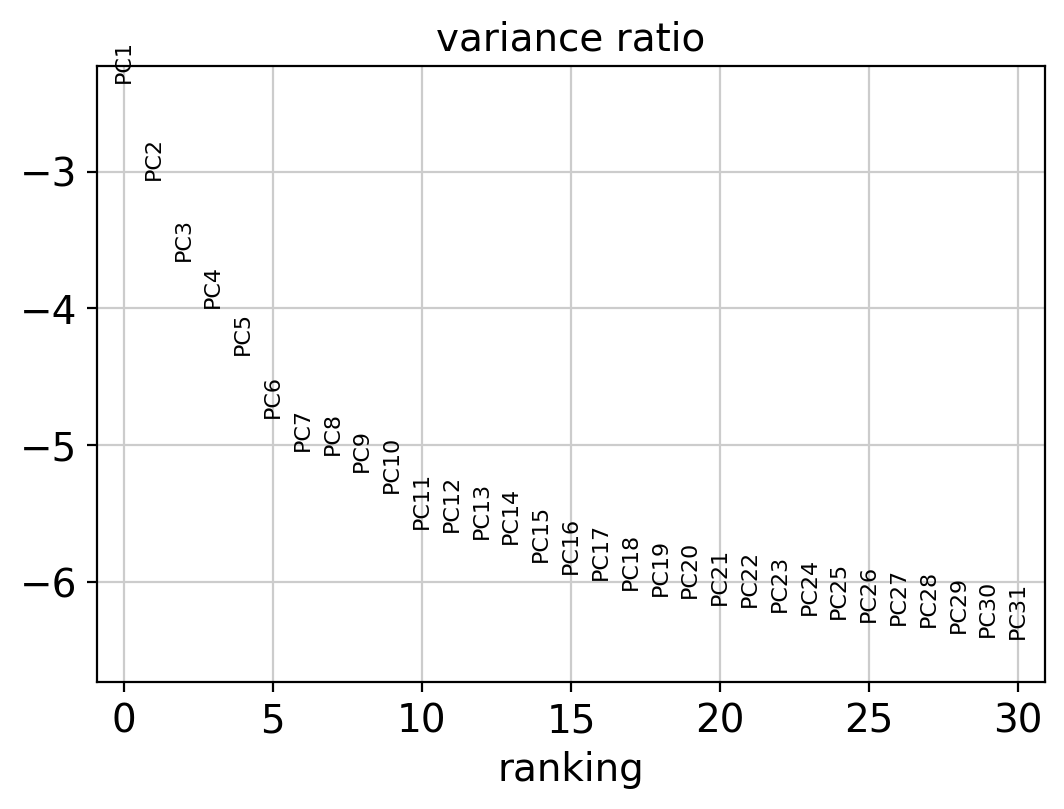

In [55]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)  # ElbowPlot



Малое число соседей (n_neighbors=2):
Отображает мелкие структуры
Плюс: видно тонкие субкластеры
Минус: график шумный, кластеры могут распадаться
Больше соседей + больше PC (n_neighbors=20, n_pcs=50):
Плотные кластеры, лучше глобальная структура
Минус: теряются мелкие различия, риск объединения схожих субпопуляций
Классические параметры (n_neighbors=40, n_pcs=10):
Хороший компромисс для визуализации и аннотации крупных клеточных популяций

In [57]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [67]:
import scanpy as sc

# Малое число соседей, 10 PC
sc.pp.neighbors(adata, n_neighbors=2, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, title='UMAP: n_neighbors=2, n_pcs=10')

# Больше соседей и больше главных компонент
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, title='UMAP: n_neighbors=20, n_pcs=50')

# Классические параметры (рекомендуемые)
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, title='UMAP: n_neighbors=40, n_pcs=10')


computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


KeyboardInterrupt: 

In [59]:
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


In [60]:
adata.obs['leiden'].value_counts()

leiden
0     2336
1     1117
2     1025
3      987
4      968
5      637
6      325
7      316
8      247
9      165
10     122
11     122
Name: count, dtype: int64

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


/home/ekhajinova/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


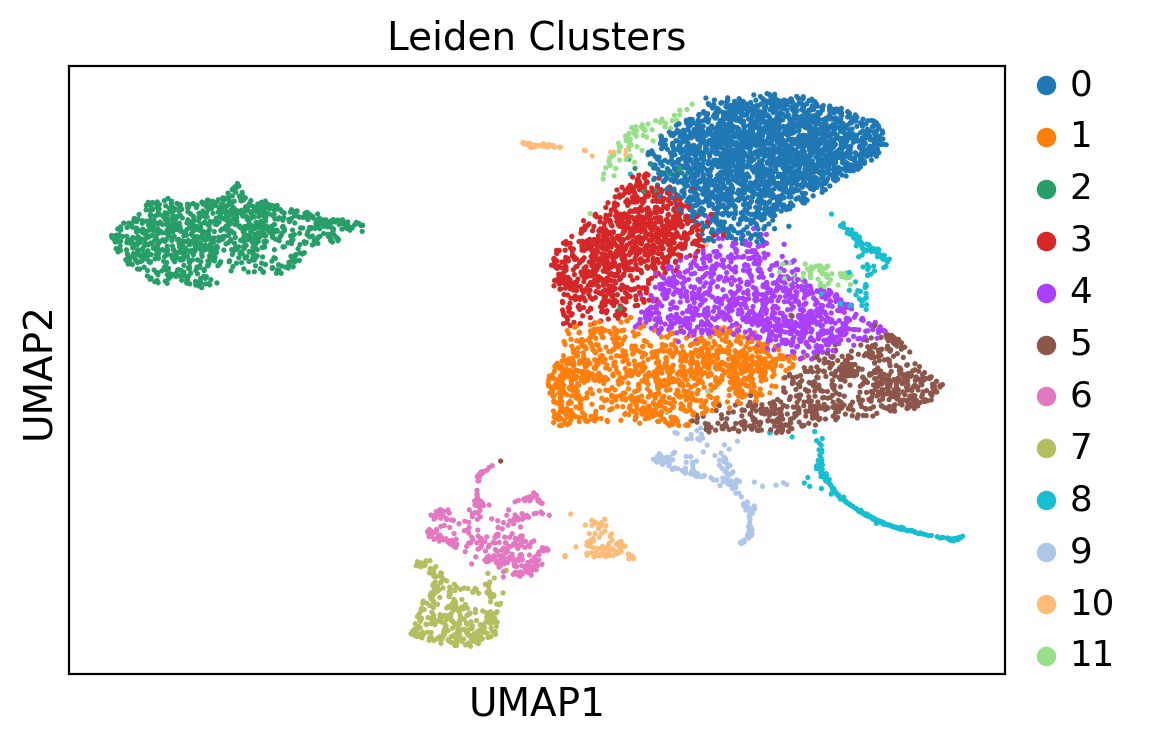

In [61]:
sc.tl.umap(adata)  # если ещё не построили
sc.pl.umap(adata, color='leiden', title='Leiden Clusters')

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


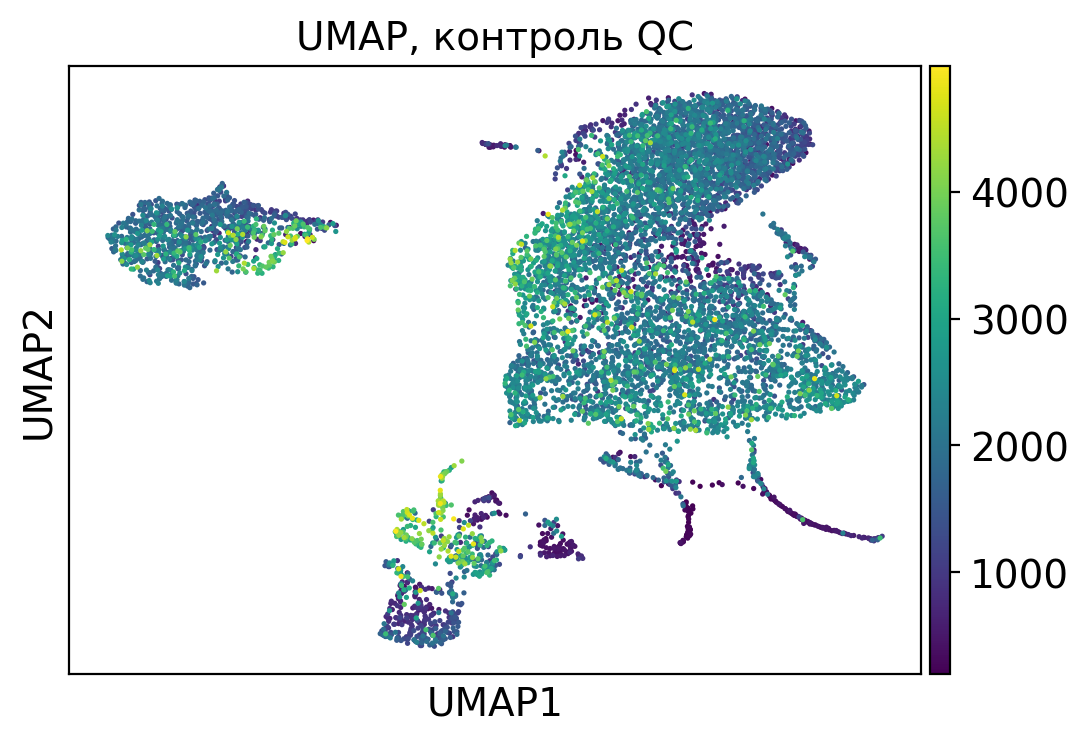

In [64]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10)  # классические параметры


sc.tl.umap(adata)


sc.pl.umap(adata, color='n_genes_by_counts', title='UMAP, контроль QC')

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


/home/ekhajinova/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


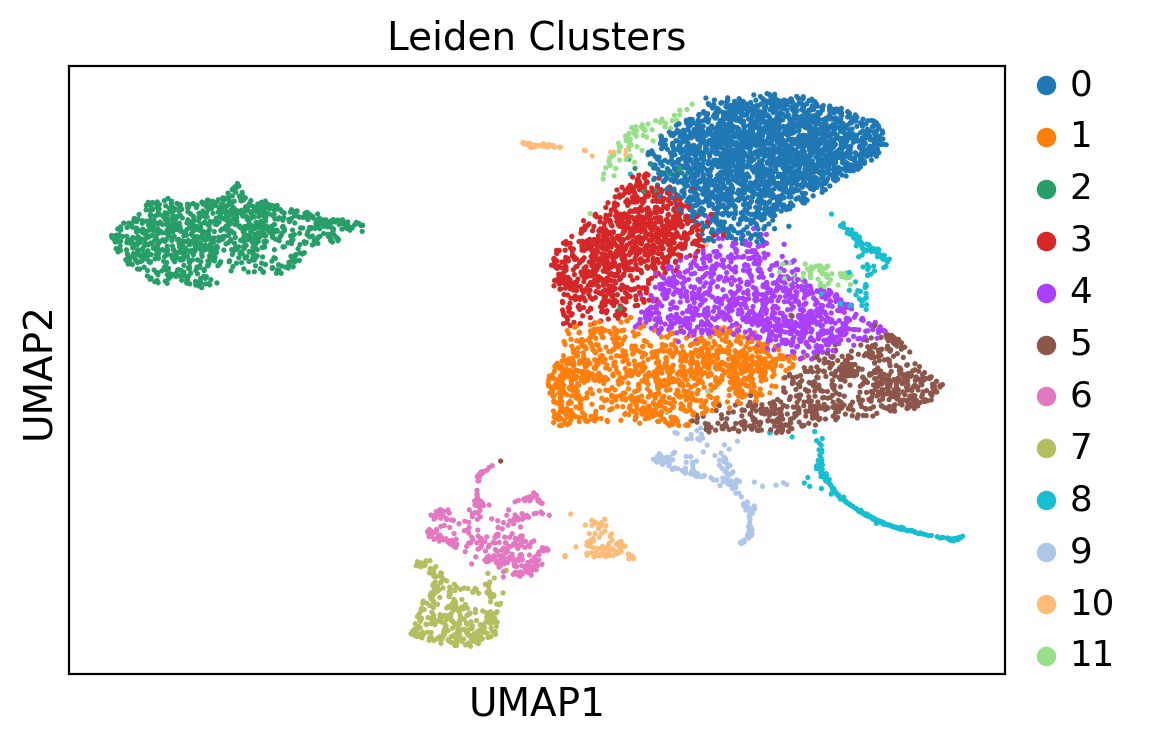

In [65]:

sc.tl.leiden(adata, resolution=0.5)


adata.obs['leiden'].value_counts()


sc.pl.umap(adata, color='leiden', title='Leiden Clusters')


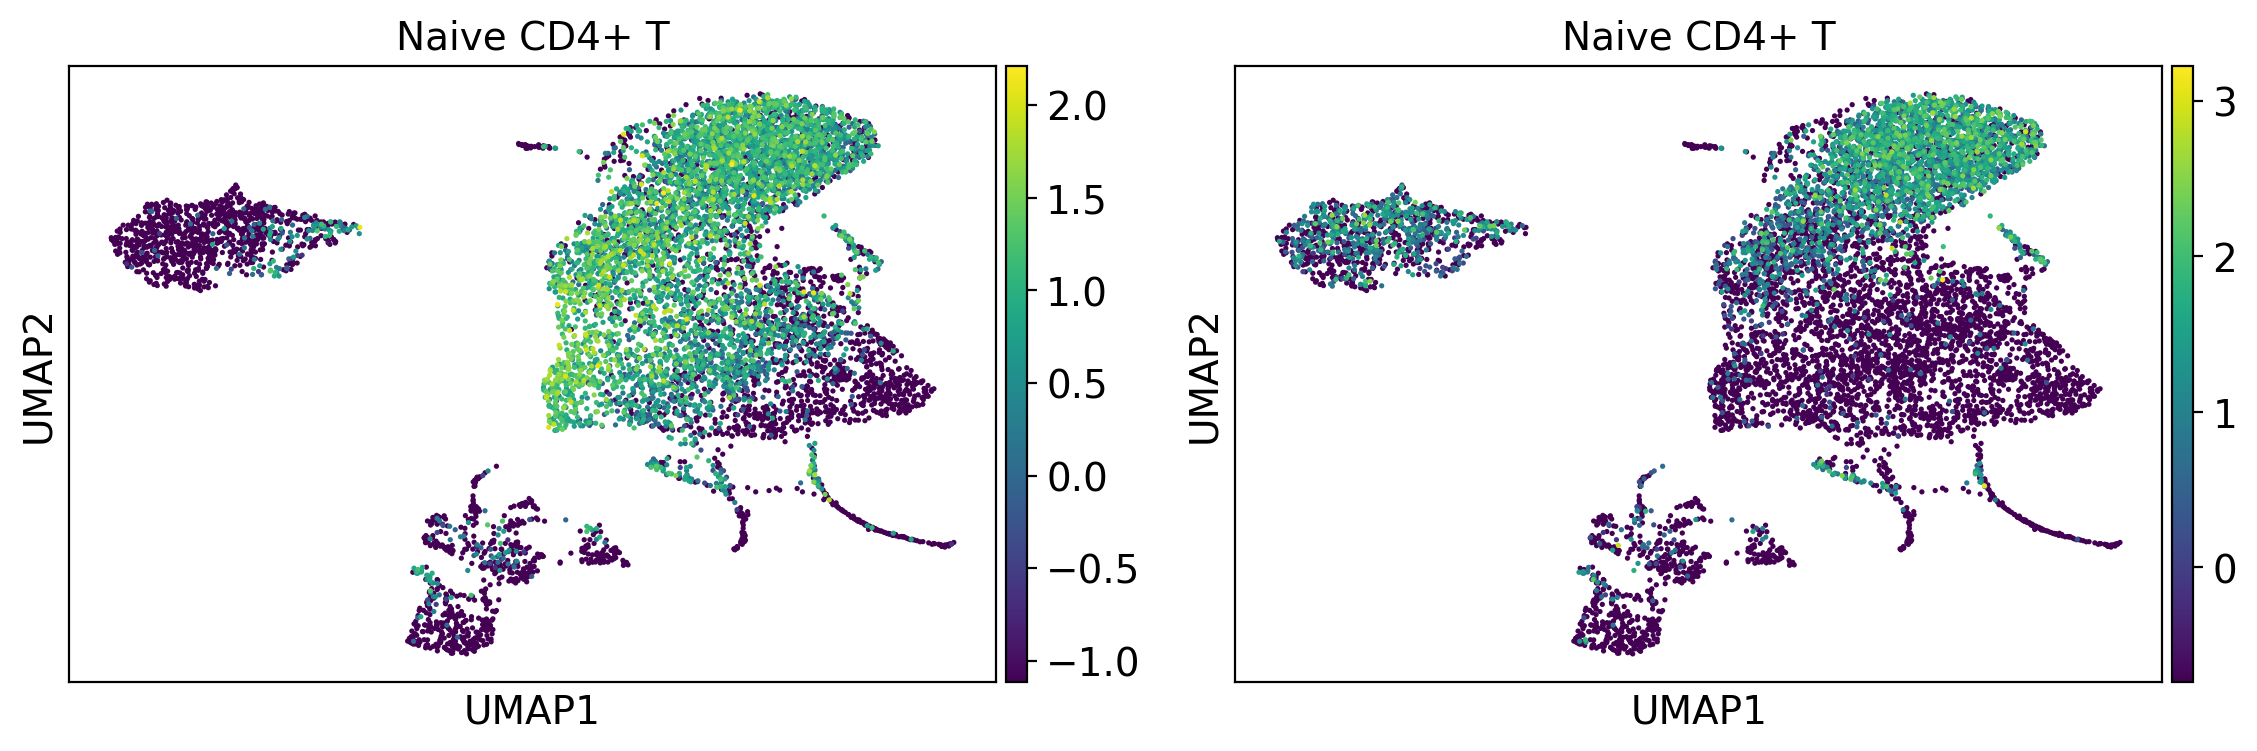

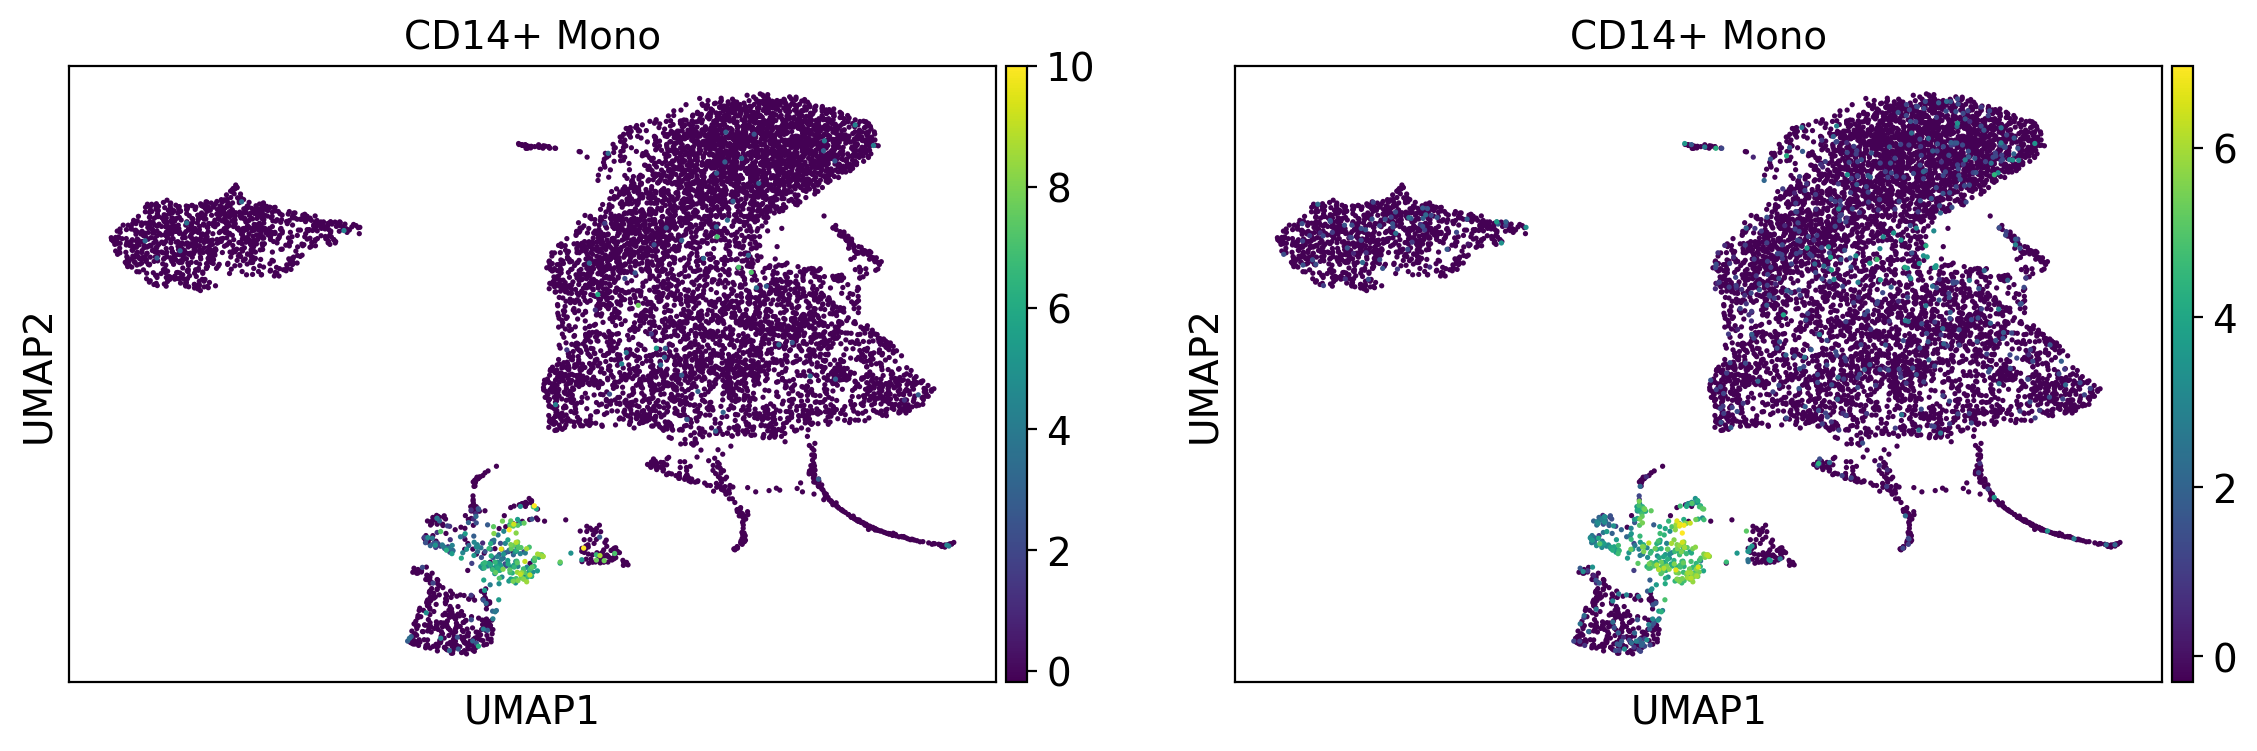

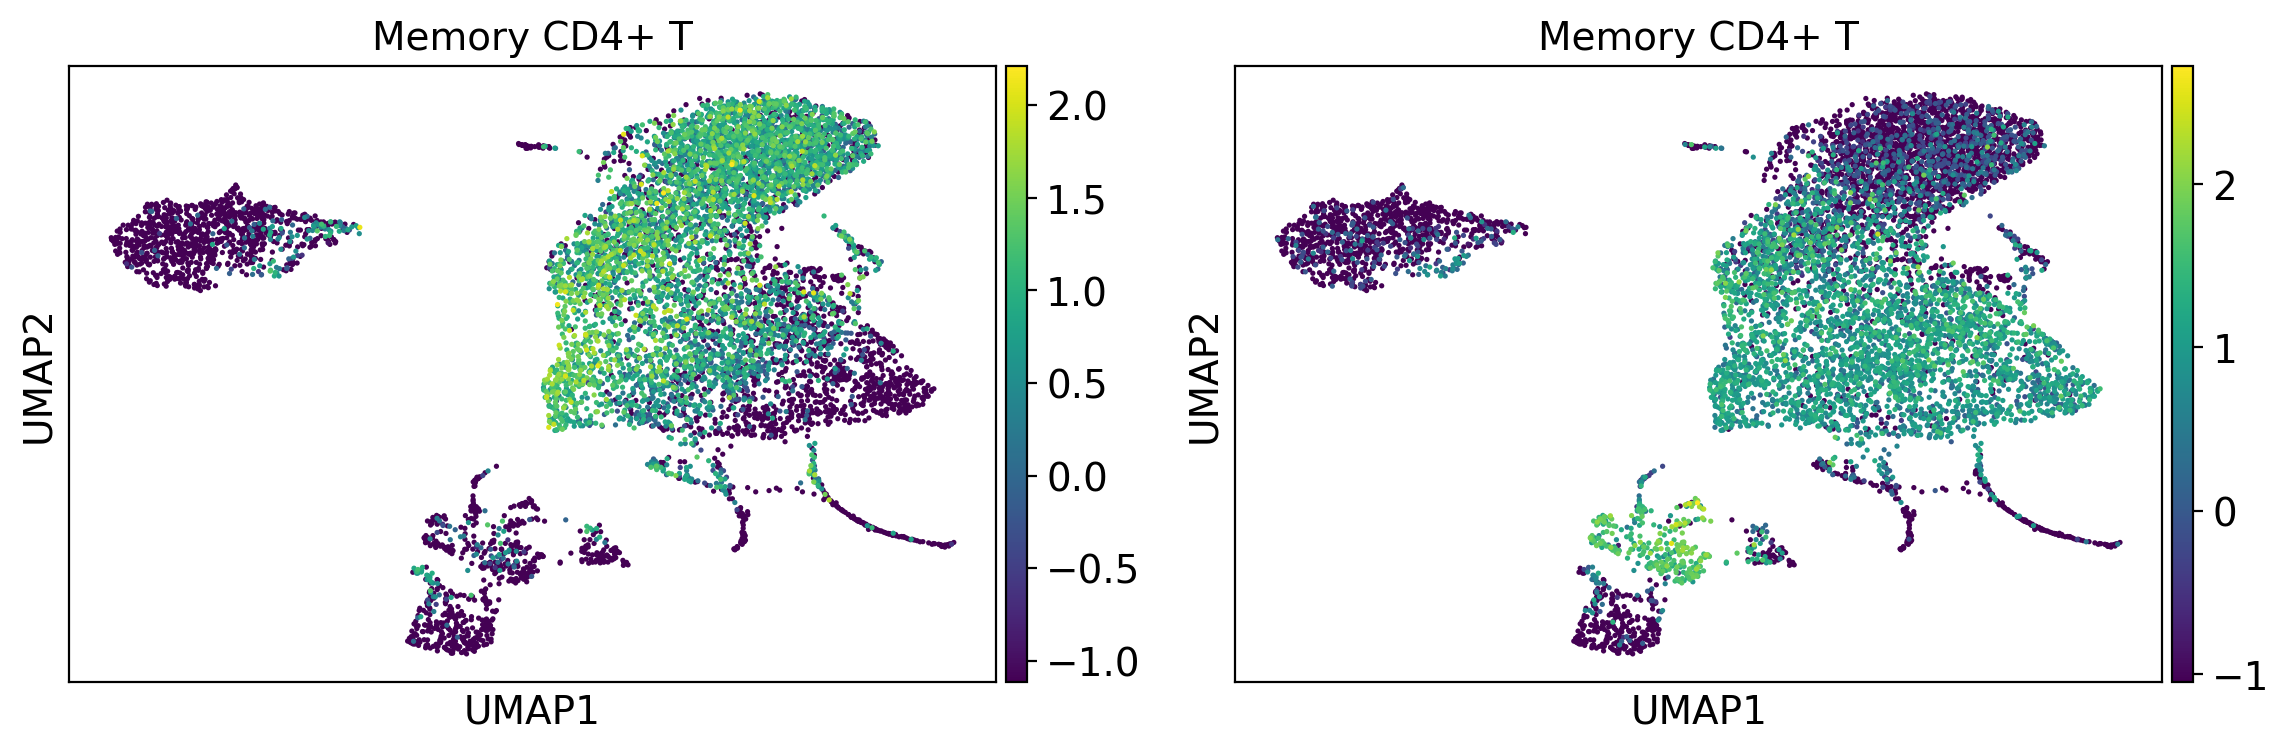

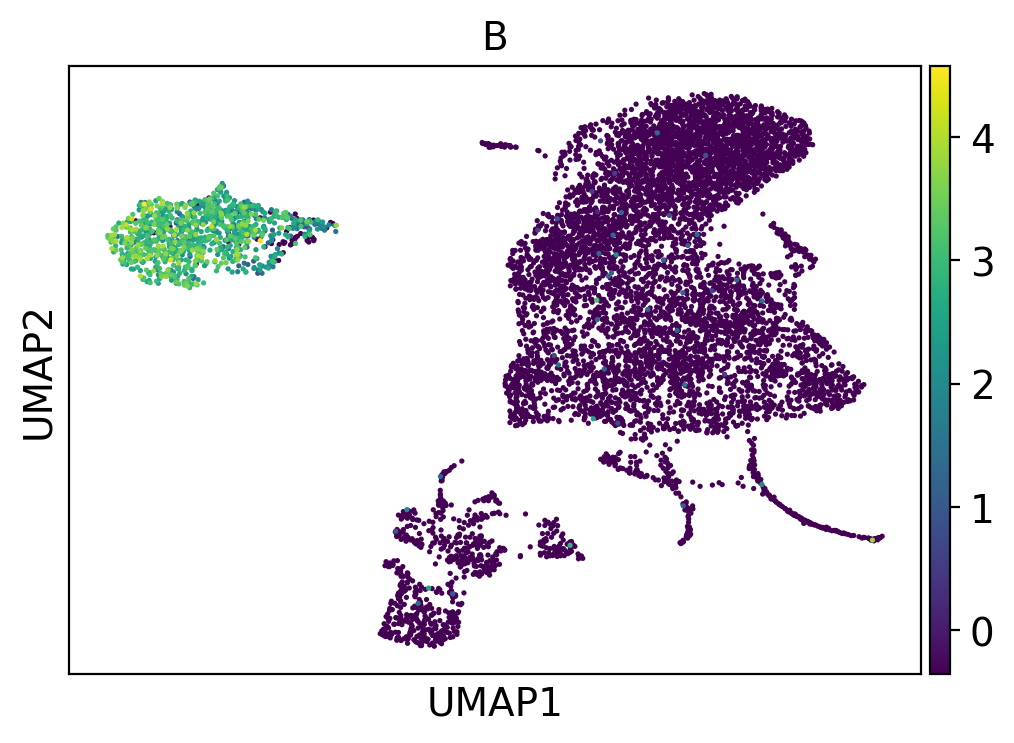

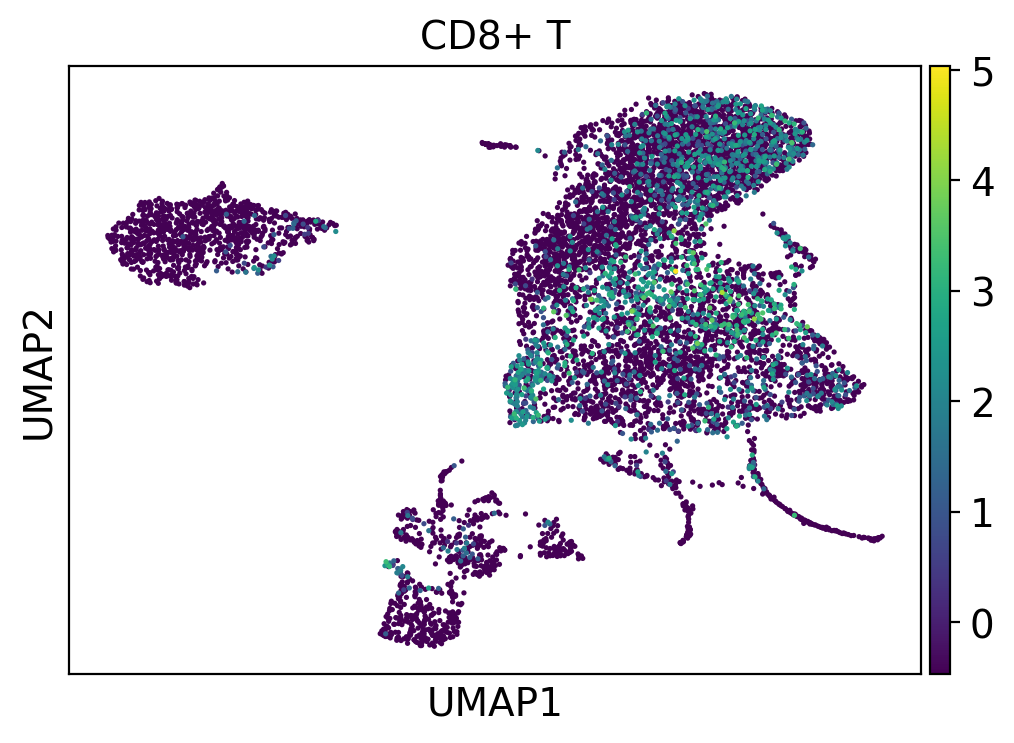

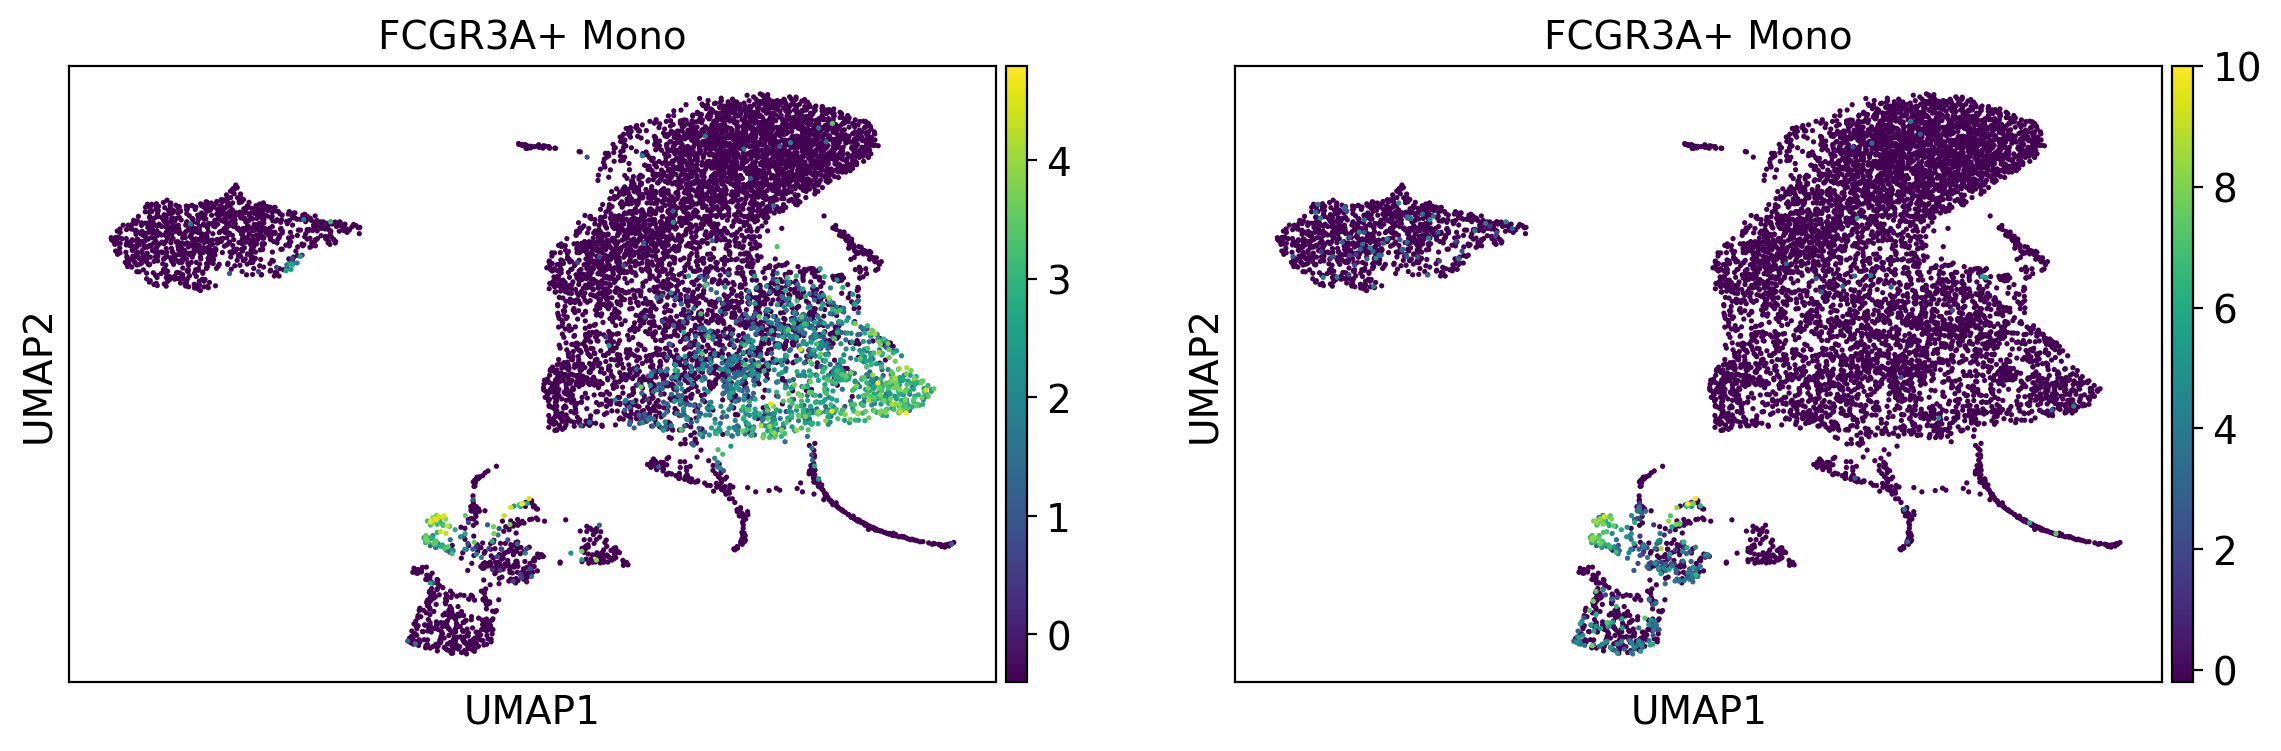

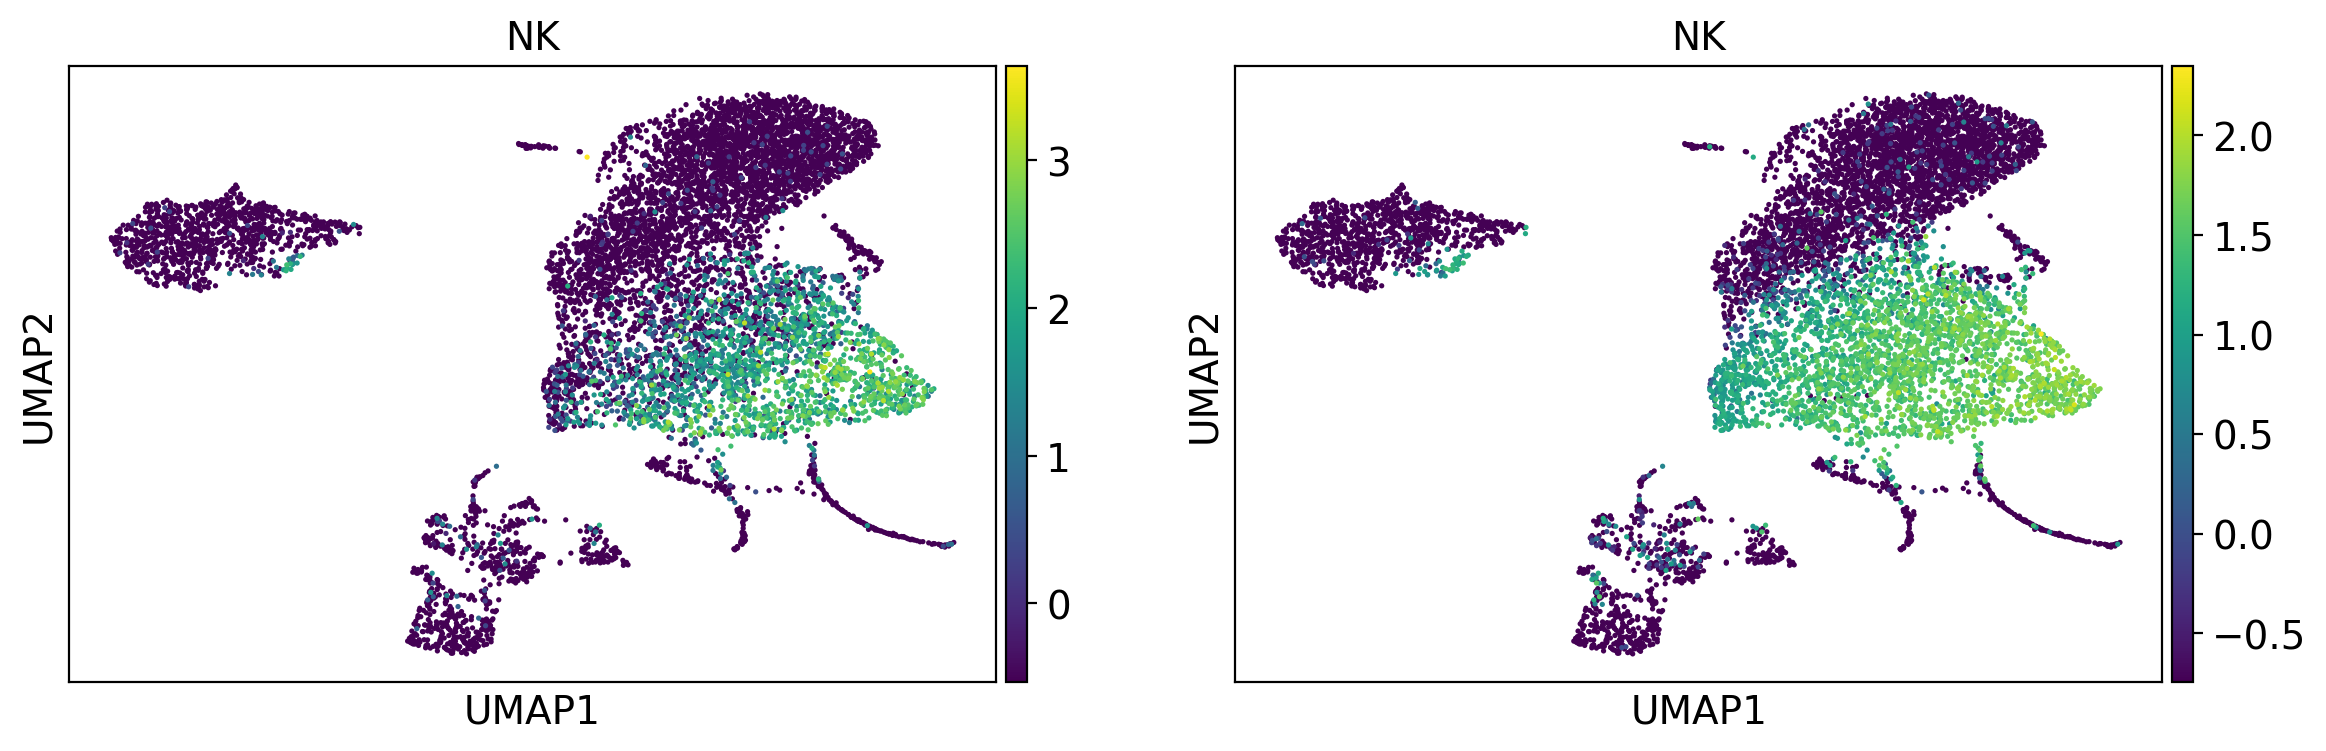

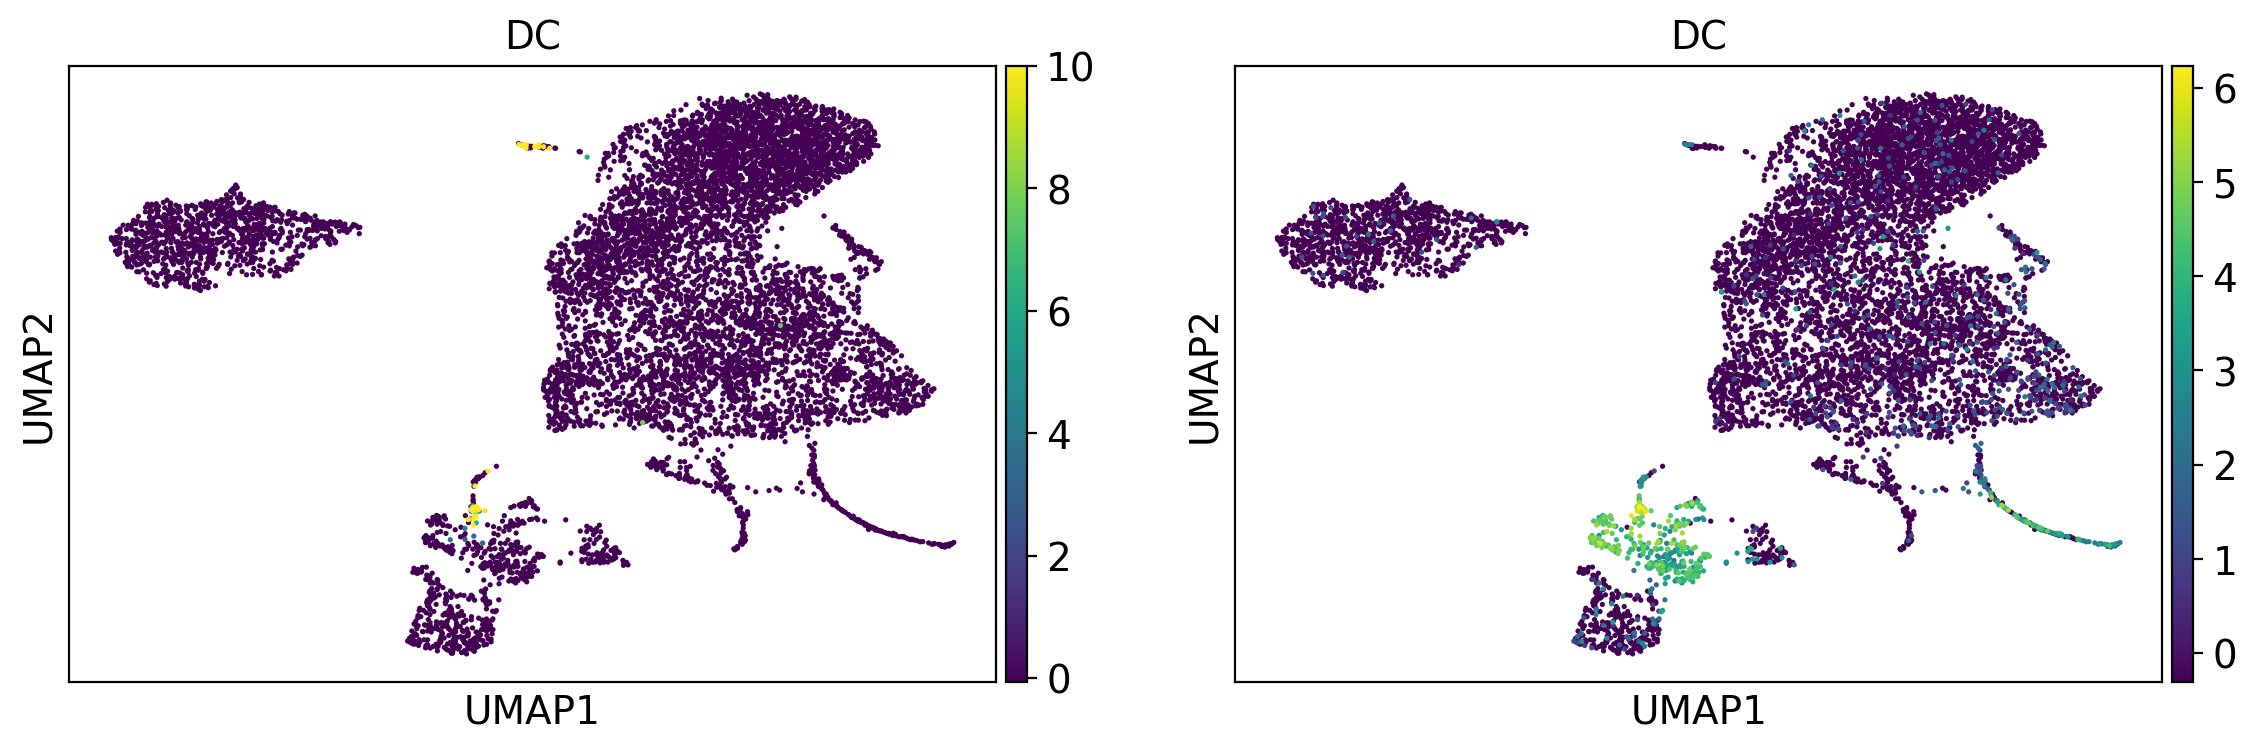

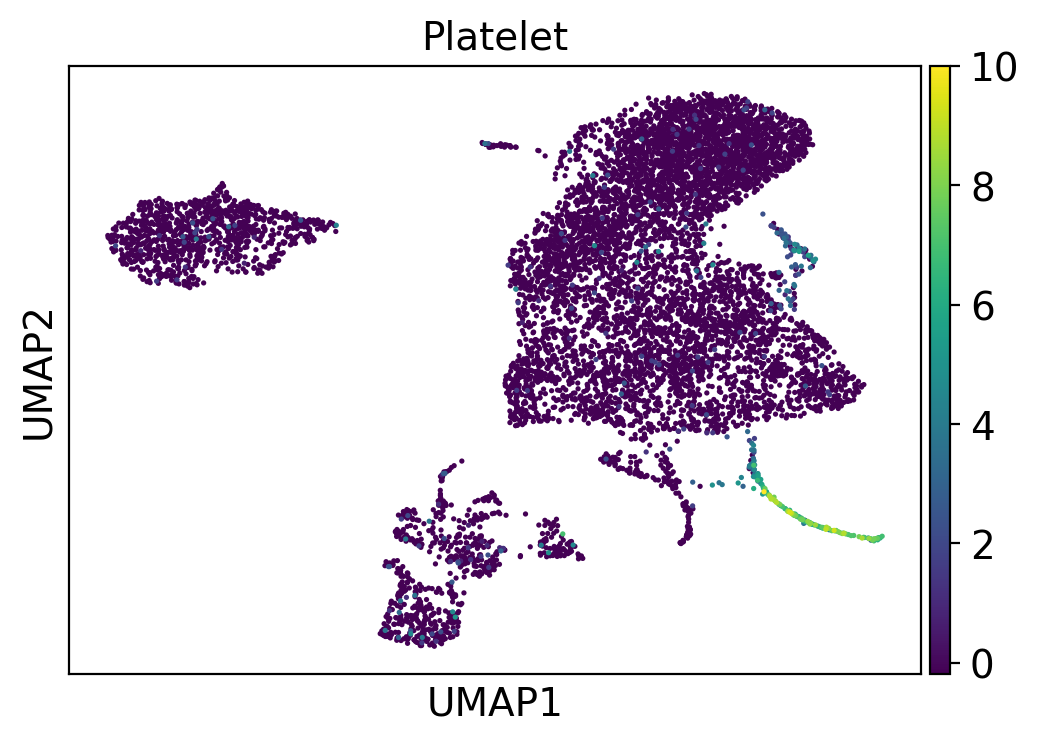

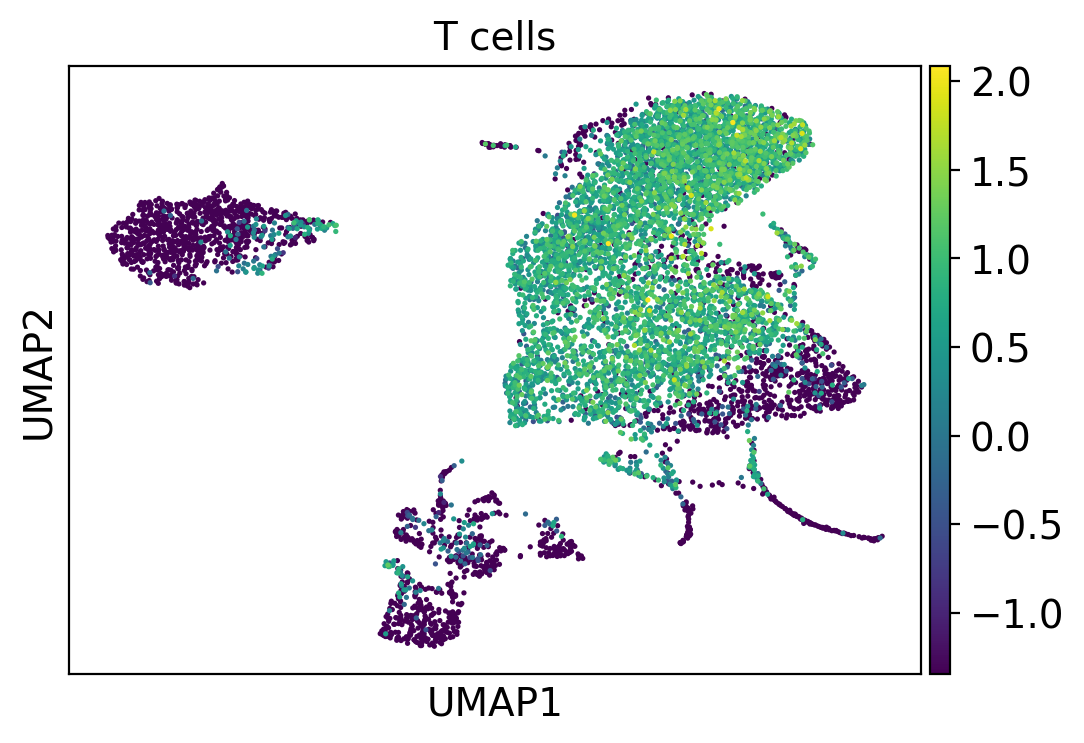

/home/ekhajinova/.local/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


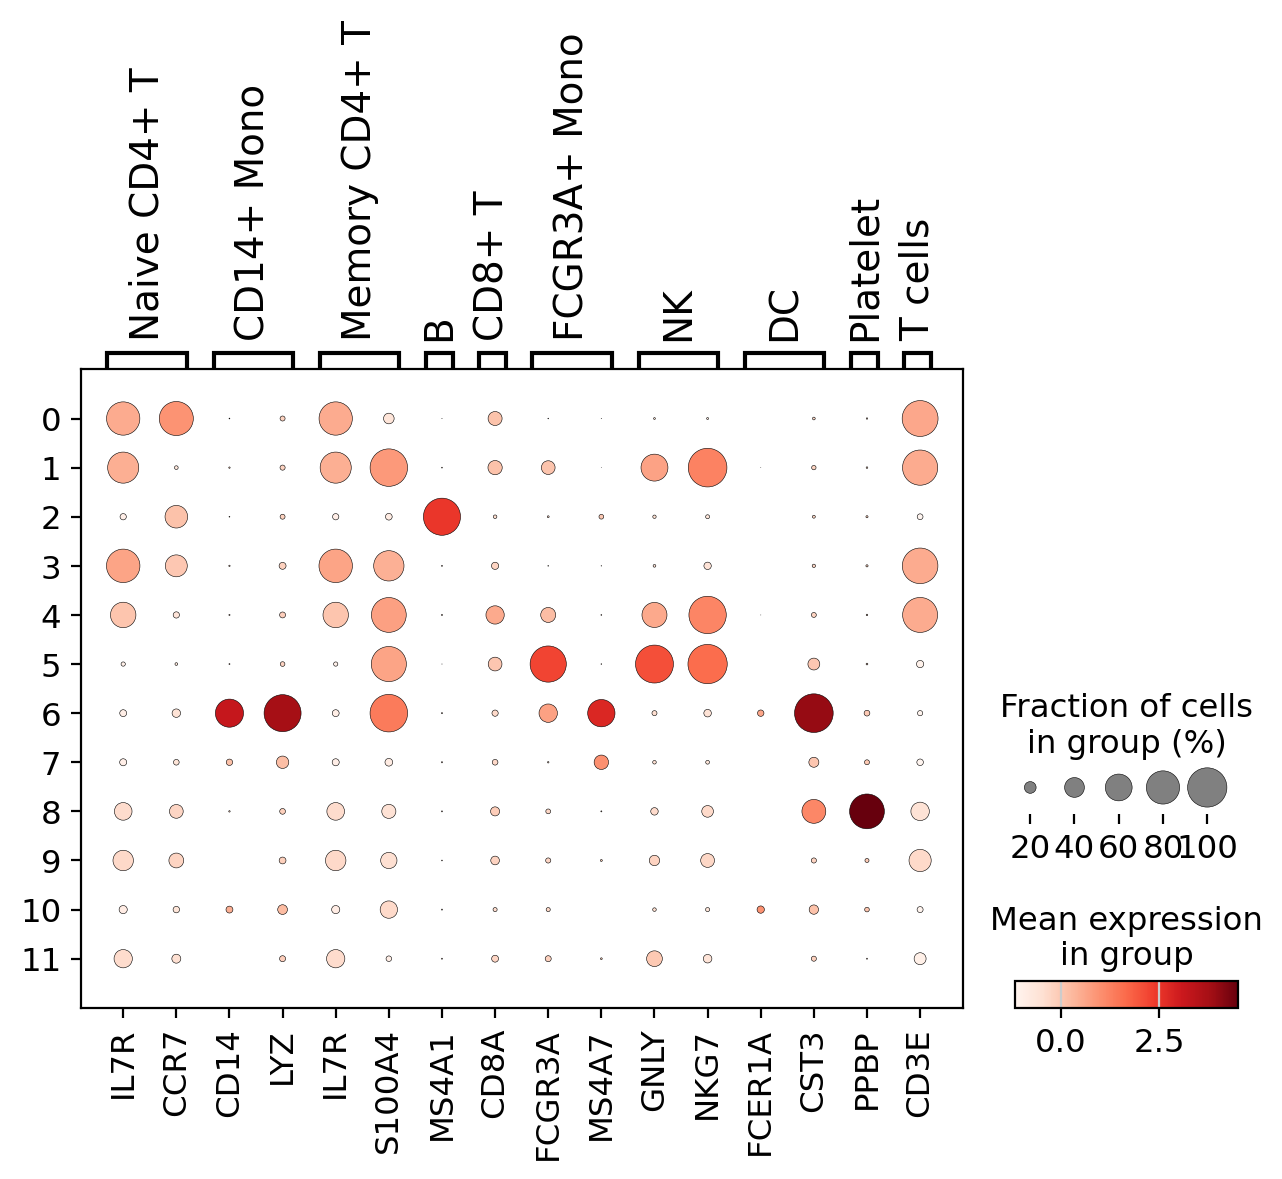

In [66]:
markers = {
    'Naive CD4+ T': ['IL7R', 'CCR7'],
    'CD14+ Mono': ['CD14', 'LYZ'],
    'Memory CD4+ T': ['IL7R', 'S100A4'],
    'B': ['MS4A1'],
    'CD8+ T': ['CD8A'],
    'FCGR3A+ Mono': ['FCGR3A', 'MS4A7'],
    'NK': ['GNLY', 'NKG7'],
    'DC': ['FCER1A', 'CST3'],
    'Platelet': ['PPBP'],
    'T cells': ['CD3E']
}

# FeaturePlot (UMAP по маркерам)
for cell_type, genes in markers.items():
    sc.pl.umap(adata, color=genes, title=[cell_type]*len(genes))

# DotPlot для наглядной аннотации кластеров
sc.pl.dotplot(adata, markers, groupby='leiden')
